In [1]:
import pandas as pd
import tqdm
from Bio import SeqIO
import os
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# import keras functions
# import tensorflow
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Input, Flatten, LSTM, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

# performance matrices
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score

# plots
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Lambda, Embedding
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
import numpy as np
from Bio import SeqIO
from numpy import array
from numpy import argmax
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.backend import expand_dims
import matplotlib.pyplot as plt
from keras.regularizers import l1, l2


from keras.models import Model
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate


from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold


2024-10-25 18:17:17.907563: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-10-25 18:17:17.907645: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def plot(history):
    # learning curves of model accuracy
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.show()

In [3]:
def get_input_for_embedding(fasta_file):
    encodings = []
    
    # define universe of possible input values
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    
    # define a mapping of chars to integers
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    int_to_char = dict((i, c) for i, c in enumerate(alphabet))
    
    for seq_record in SeqIO.parse(fasta_file, "fasta"):
        data = seq_record.seq
        for char in data:
            if char not in alphabet:
                return
        integer_encoded = [char_to_int[char] for char in data]
        encodings.append(integer_encoded)
    encodings = np.array(encodings)
    return encodings

In [10]:
# convert sequences to integer encoding, for embedding
test_positive_embedding = get_input_for_embedding('../data/test/fasta/test_positive_sites.fasta')
test_negative_embedding = get_input_for_embedding('../data/test/fasta/test_negative_sites.fasta')
train_positive_embedding = get_input_for_embedding('../data/train/fasta/positive_sites.fasta')
train_negative_embedding = get_input_for_embedding('../data/train/fasta/negative_sites.fasta')

# create labels
train_positive_labels = np.ones(train_positive_embedding.shape[0])
train_negative_labels = np.zeros(train_negative_embedding.shape[0])
test_positive_labels = np.ones(test_positive_embedding.shape[0])
test_negative_labels = np.zeros(test_negative_embedding.shape[0])

# stack positive and negative data together
X_train_full_embedding = np.vstack((train_positive_embedding,train_negative_embedding))
X_test_embedding = np.vstack((test_positive_embedding,test_negative_embedding))
y_train_full = np.concatenate((train_positive_labels, train_negative_labels), axis = 0)
y_test = np.concatenate((test_positive_labels, test_negative_labels), axis = 0)

train_positive_pt5 = pd.read_csv("../data/train/features/train_positive_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]
train_negative_pt5 = pd.read_csv("../data/train/features/train_negative_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]
test_positive_pt5 = pd.read_csv("../data/test/features/test_positive_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]
test_negative_pt5 = pd.read_csv("../data/test/features/test_negative_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]

# stack positive and negative data together
X_train_pt5_full = np.vstack((train_positive_pt5,train_negative_pt5))
X_test_pt5 = np.vstack((test_positive_pt5,test_negative_pt5))


In [8]:
# shuffle X and y together
# X_train_pt5_full, X_train_full_embedding, y_train = shuffle(X_train_pt5_full, X_train_full_embedding, y_train_full)
# X_test_pt5, X_test_embedding, y_test = shuffle(X_test_pt5, X_test_embedding, y_test)

In [42]:
# model.summary()
# plot_model(model, show_shapes=True)

In [7]:
def CNN_Embedding():
    # Embedding
    model = Sequential()
    model.add(Embedding(256, 21, input_length=33))
    model.add(Lambda(lambda x: K.expand_dims(x, 3)))
    model.add(Conv2D(32, kernel_size=(17, 3), activation = 'relu', kernel_initializer='he_normal', padding = 'VALID'))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(16, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

### Iterated 10-Fold CROSS VALIDATION

In [11]:
kfold = KFold(10, shuffle=True)

# initialize average variables
avg_acc, avg_mcc, avg_sp, avg_sn = 0, 0, 0, 0

for train, val in kfold.split(X_train_full_embedding, y_train_full):

    # Early stopping
    es = EarlyStopping(monitor='val_accuracy', patience=3, mode='auto')

    # Checkpointer
    metric = 'val_accuracy'
    checkpointer = ModelCheckpoint(filepath="../models/st_model_best.h5",
                            monitor = metric,
                            verbose=0, 
                            save_weights_only=False,
                            save_best_only=True)

    model = CNN_Embedding()
    model.compile(optimizer=Adam(learning_rate=1e-3),
              loss=BinaryCrossentropy(),
              metrics=['accuracy'])

    # seperate val data
    X_train, X_val = X_train_full_embedding[train], X_train_full_embedding[val]
    y_train, y_val = y_train_full[train], y_train_full[val]

    # Training and Evaluation
    history = model.fit(X_train, y_train, batch_size=256, epochs=100, verbose=1, callbacks=[checkpointer],
                            validation_data=(X_val, y_val))


    y_pred = model.predict(X_val).reshape(y_val.shape[0],)

    y_pred = (y_pred > 0.5)
    y_pred = [int(i) for i in y_pred]
    y_val = np.array(y_val)
    y_pred = np.array(y_pred)

    cm = confusion_matrix(y_val, y_pred)
    mcc = matthews_corrcoef(y_val, y_pred)
    acc = accuracy_score(y_val, y_pred)
    sn = cm[1][1]/(cm[1][1]+cm[1][0])
    sp = cm[0][0]/(cm[0][0]+cm[0][1])
    print(acc,mcc,sn,sp)
    # plot(history)

Epoch 1/100
34/34 [==============================] - 2s 43ms/step - loss: 0.6891 - accuracy: 0.5425 - val_loss: 0.6798 - val_accuracy: 0.6158
Epoch 2/100
34/34 [==============================] - 1s 39ms/step - loss: 0.6631 - accuracy: 0.6127 - val_loss: 0.6509 - val_accuracy: 0.6337
Epoch 3/100
34/34 [==============================] - 1s 39ms/step - loss: 0.6329 - accuracy: 0.6470 - val_loss: 0.6297 - val_accuracy: 0.6484
Epoch 4/100
34/34 [==============================] - 1s 37ms/step - loss: 0.6130 - accuracy: 0.6662 - val_loss: 0.6347 - val_accuracy: 0.6442
Epoch 5/100
34/34 [==============================] - 1s 38ms/step - loss: 0.6074 - accuracy: 0.6729 - val_loss: 0.6162 - val_accuracy: 0.6695
Epoch 6/100
34/34 [==============================] - 1s 38ms/step - loss: 0.5973 - accuracy: 0.6903 - val_loss: 0.6100 - val_accuracy: 0.6600
Epoch 7/100
34/34 [==============================] - 1s 38ms/step - loss: 0.5893 - accuracy: 0.6936 - val_loss: 0.6048 - val_accuracy: 0.6800
Epoch 

In [12]:
cm

array([[309, 160],
       [109, 371]])

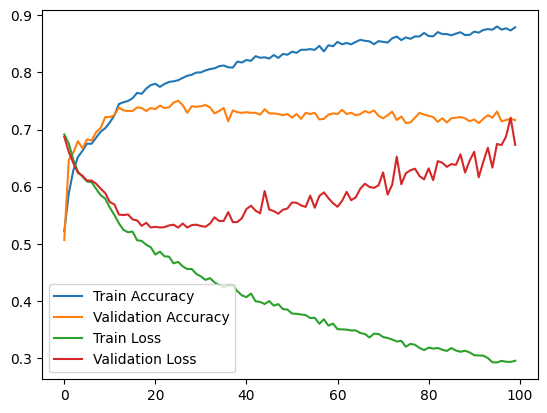

In [13]:
plot(history)